In [122]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


In [123]:
import cv2
import torch
import imageio
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

from tqdm.notebook import tqdm
from torch import Tensor
from itertools import compress, cycle
from collections import OrderedDict
from scipy.interpolate import griddata
from IPython.display import Image

from utilities.utils import *

from src.plotting import Plotter
from src.gl_solver import GLSolver
from src.parameters_init import ParametersInit
from src.random_input_field import RandomInputField

import warnings
warnings.filterwarnings('ignore')

EPOCHS = 20_000
LR = 1
# SEED = 1234

# np.random.seed(SEED)
# torch.manual_seed(SEED)
# torch.cuda.manual_seed(SEED)
# torch.cuda.manual_seed_all(SEED)
# torch.set_default_tensor_type(torch.FloatTensor)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [124]:
Nx=4
Ny=4

Lx=30 
Ly=30

T_end = 1
dt = 0.005

N_ITERATIONS = int(T_end / dt)

In [125]:
A_norm, A_original, mem_rate, myu_original = compute_A_norm(
    Nx=Nx, 
    Ny=Ny, 
    input_to_defect_ratio=2*2, 
    mean=5.4, 
    std_deviation=0.8, 
    time_period=25, 
    Lx=Lx, 
    Ly=Ly, 
    dt=dt, 
    T_End=T_end, 
    parallel_runs=1, 
    input_scale=0.75, 
    mem_coef=1, 
    time_period_parameter=100, 
    _mean=5.4, 
    std_deviation_run_computation=1,
    input_myu=None
)

100%|██████████| 200/200 [00:00<00:00, 2985.11it/s]

Unique Myus count	 8
Max value of myu:	 104.14104515595743
Min value of myu:	 28.893477672414086
Unique values: [28.893477672414086, 53.20229459360476, 58.107982450278136, 66.83168520679922, 73.33809836951713, 81.01192118026599, 85.93150003649163, 104.14104515595743]
Counts:		 [400 400 400 400 400 400 400 400]
A.shape=(1, 200, 4, 4),
Myu.shape=(1, 200, 4, 4),

Any NaN values in Myu		 False
Any NaN values in A_original	 False


In [126]:
def output_plot(data, mem_rat, save_fig=False, file_name="A_in_norm_80%04d.png"):
    fig = plt.figure(1, figsize=(6.5, 6.5))
    for index in tqdm(range(mem_rat)):
        if index % 2 == 0:
            plt.clf()
            plt.imshow(data[index, :, :], origin='lower', vmax=0.9*np.max(data))
            plt.colorbar()
            if save_fig:
                filename = file_name % (index/2)
                plt.savefig(filename)

100%|██████████| 200/200 [00:07<00:00, 25.56it/s]


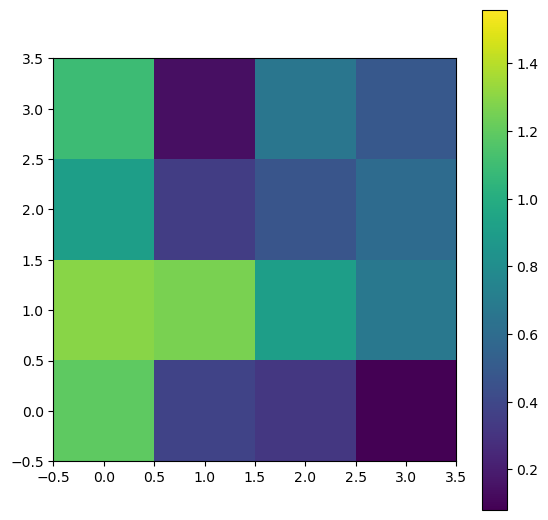

In [127]:
output_plot(A_norm, mem_rate)

GETTING HANDS DIRTY WITH THE NEURAL NETWORKS

In [128]:
snn_layers = [3, 20, 20, 20, 20, 20, 20, 20, 20, 1]

x = np.linspace(0, Lx, Nx).flatten()[:, None]
y = np.linspace(0, Ly, Ny).flatten()[:, None]
t = np.linspace(0, T_end, N_ITERATIONS).flatten()[:, None]

Exact = A_original.squeeze(0)

X, T, Y = np.meshgrid(x, t, y)

X_star = np.hstack((X.flatten()[:, None], Y.flatten()[:, None], T.flatten()[:, None]))
u_star = Exact.flatten()
u_star = np.hstack([u_star.real[:, None],u_star.imag[:, None]])

In [129]:
X_star.shape, u_star.shape

((3200, 3), (3200, 2))

$$
\begin{aligned}
\partial_{t} A &= \mu A+\Delta A-|A|^{2} A
\end{aligned}
$$

In [130]:
class LOSS:
  def __init__(self, x, y, t, verbose = 0):
      self.msef = nn.MSELoss()
      self.MSE = []
      self.F = []
      self.FMSE = []
      self.verbose = verbose
      self.x = x
      self.y = y
      self.t = t

  def load(self,y_pred,y_real):
      self.y_pred = y_pred
      self.y_real = y_real

    
  def plot(self):
    fig, [upper,lower] = plt.subplots(nrows=2)
    upper.plot(self.MSE)
    upper.legend("MSE")
    upper.set_title("MSE")
    upper.set_yscale('log')
    lower.plot(self.FMSE)
    lower.legend("FMSE")
    lower.set_title("FMSE")
    lower.set_yscale('log')
    plt.show()

  def mse(self):
      loss = self.msef(self.y_pred,self.y_real)
      if(self.verbose):
        print(f"MSELOSS: {loss}")
      self.MSE.append(loss.cpu().detach().numpy())
      return loss

  def fmse(self, myu):
    f_loss = torch.mean(torch.abs(self.net_f(myu)) ** 2)
    self.FMSE.append(f_loss.cpu().detach().numpy())
    return f_loss

  def __radd__(self, other):
    if other == 0:
        return self
    else:
        return self.__add__(other)  
  def __add__(self, L):
    l = LOSS(self.x,self.y,self.t, verbose = self.verbose)
    if "y_pred" in dir(self):
        l.load(self.y_pred, self.y_real)
    if "y_pred" in dir(L):
        l.load(L.y_pred, L.y_real)
    l.MSE = self.MSE + L.MSE
    l.FMSE = self.FMSE + L.FMSE
    l.F = self.F + L.F
    return l

  def net_f(self, myu, verbose = 0):
        torch.autograd.set_detect_anomaly(True)
        x,y,t = self.x, self.y, self.t

        ru = self.y_pred[:,0]
        iu = self.y_pred[:,1]

        (ru_t, ru_x, ru_y) = torch.autograd.grad(ru, (t, x, y), grad_outputs=torch.ones_like(ru), create_graph=True, retain_graph=True)
        (iu_t, iu_x, iu_y) = torch.autograd.grad(iu, (t, x, y), grad_outputs=torch.ones_like(iu), create_graph=True, retain_graph=True)

        (ru_xx,) = torch.autograd.grad(ru_x, (x), grad_outputs=torch.ones_like(ru_x), create_graph=True)
        (iu_xx,) = torch.autograd.grad(iu_x, (x), grad_outputs=torch.ones_like(iu_x), create_graph=True)

        (ru_yy,) = torch.autograd.grad(ru_y, (y), grad_outputs=torch.ones_like(ru_y), create_graph=True)
        (iu_yy,) = torch.autograd.grad(iu_y, (y), grad_outputs=torch.ones_like(iu_y), create_graph=True)

        u =( ru + iu * 1j).view(200, 4, 4)
        u_t = (ru_t + iu_t * 1j).view(200, 4, 4)
        u_xx =( ru_xx + iu_xx *1j).view(200, 4, 4)
        u_yy = (ru_yy + iu_yy *1j).view(200, 4, 4)

        if(verbose):
            print('u_t:',u_t)
            print('u:',u)
            print('u_xx:',u_xx)
            print('u_yy:',u_yy)
            
        f = u_t - myu*u - (u_xx + u_yy) + torch.pow(torch.abs(u), 2)*u
        free_memory(u, u_t, u_xx, u_yy)

        return f
def free_memory(*variables):
    del variables
    torch.cuda.empty_cache()

In [131]:
from torch.optim import LBFGS

class OVERNET(nn.Module):
    def __init__(self, layers):
        super(OVERNET, self).__init__()
        
        self._depth = len(layers) - 1
        self._activation_function = torch.nn.Softplus
        layers_list = list()

                            
        for i in range(self._depth - 1):
            layers_list.append(('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1], dtype = torch.float64)))
            layers_list.append(('activation_%d' % i, self._activation_function()))

        layers_list.append(('layer_%d' % (self._depth - 1), torch.nn.Linear(layers[-2], layers[-1], dtype = torch.float64)))
        layerDict = OrderedDict(layers_list)
        self._nn = torch.nn.Sequential(layerDict)        
        self.optimizer = torch.optim.Adam(params = self._nn.parameters(), lr=0.01)
        
    
    def forward(self, x):
        return self._nn(x)

    def predict(self, x):
        self._Wtmx.eval()
        if type(x) is not torch.Tensor:
            x = torch.tensor(x, dtype = torch.float64).to(device)
        y =  self.forward(x).cpu().detach().numpy()
        return y[:,0] + y[:,1]*1j    

    def fastmselbfgstrain(self, x, y, epochs=100):
        x = torch.tensor(x, dtype=torch.float64).to(device)
        y = torch.tensor(y, dtype=torch.float64).to(device)
        optimizer = torch.optim.LBFGS(params = self._nn.parameters())

        lossf = nn.MSELoss()
        L = []

        def closure():
            self.optimizer.zero_grad()
            y_pred = self.forward(x)
            loss = lossf(y_pred, y)
            L.append(loss.cpu().detach().numpy())
            loss.backward()
            return loss
        for _ in tqdm(range(epochs)):
            self.optimizer.step(closure)

        return L
      
    def fastmselbfgstrain(self, x, y, epochs=100):
        x = torch.tensor(x, dtype=torch.float64).to(device)
        y = torch.tensor(y, dtype=torch.float64).to(device)
        optimizer = torch.optim.LBFGS(params = self._nn.parameters())

        lossf = nn.MSELoss()
        L = []

        def closure():
            self.optimizer.zero_grad()
            y_pred = self.forward(x)
            loss = lossf(y_pred, y)
            L.append(loss.cpu().detach().numpy())
            loss.backward()
            return loss
        for _ in tqdm(range(epochs)):
            optimizer.step(closure)

        return L
              
    def fastmsetrain(self, x, y, epochs=100):
        x = torch.tensor(x, dtype = torch.float64).to(device)
        y = torch.tensor(y, dtype = torch.float64).to(device)
        
        self.optimizer.zero_grad()
        lossf = nn.MSELoss()
        L = []
        
        for _ in tqdm(range(epochs)):
            y_pred = self.forward(x)
            loss = lossf(y_pred,y)
            L.append(loss.cpu().detach().numpy())
            loss.backward()
            self.optimizer.step()
            self._nn.zero_grad()       

        return L   

In [133]:
import torch
torch.cuda.empty_cache()
torch.autograd.set_detect_anomaly(False)
torch.manual_seed(0)
net = OVERNET([3,8,32,64,32,8,2]).to(device)
L1 = net.fastmsetrain(x = X_star, y = u_star, epochs = 100000)

100%|██████████| 100000/100000 [11:07<00:00, 149.75it/s]


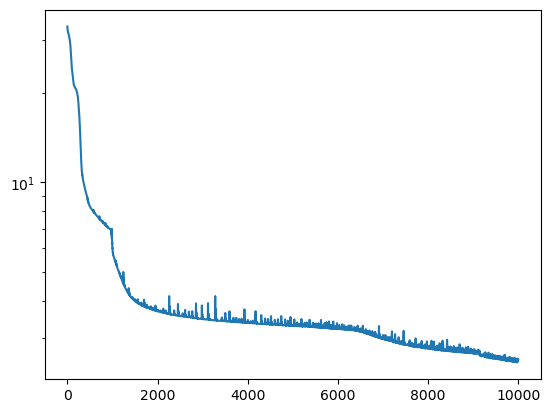

In [121]:
plt.plot(L)
plt.yscale('log')

In [105]:
net.optimizer.param_groups[0]['lr'] = 0.001
L2 = net.fastmsetrain(x = X_star, y = u_star, epochs = 10000)

100%|██████████| 10000/10000 [00:38<00:00, 258.25it/s]


In [106]:
net.optimizer.param_groups[0]['lr'] = 0.0001
L3 = net.fastmsetrain(x = X_star, y = u_star, epochs = 10000)

100%|██████████| 100000/100000 [06:45<00:00, 246.41it/s]


In [107]:
L4 = net.fastmselbfgstrain(x = X_star, y = u_star, epochs = 100)

100%|██████████| 100/100 [00:58<00:00,  1.71it/s]


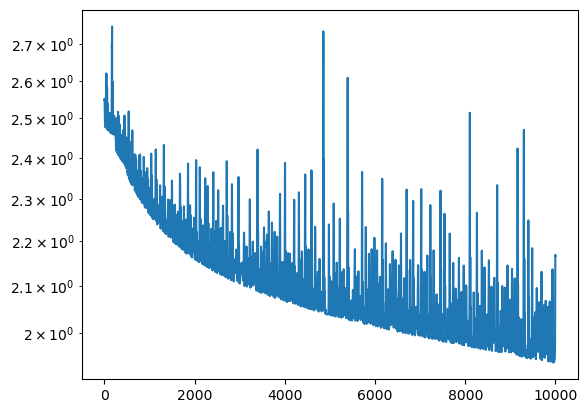

In [134]:
plt.plot(L2)
plt.yscale('log')

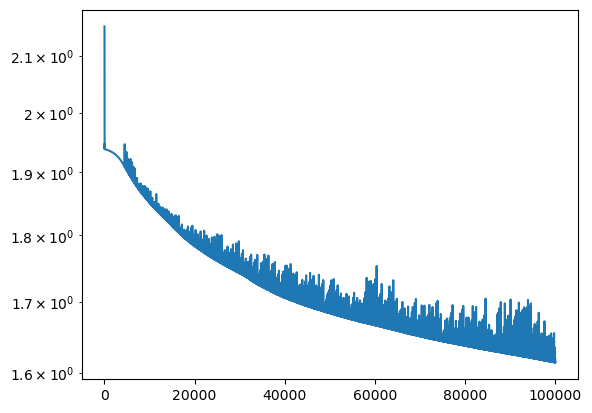

In [110]:
plt.plot(L3)
plt.yscale('log')

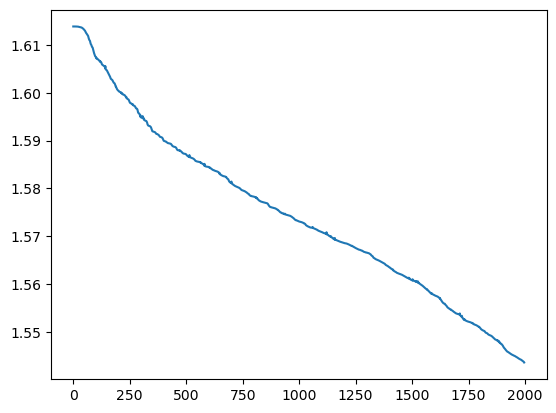

In [112]:
plt.plot(L4[3:])

In [11]:
class VAHANNET(nn.Module):
    def __init__(self, layers):
        super(VAHANNET, self).__init__()

        self._depth = len(layers) - 1
        self._activation_function = torch.nn.Softplus
        layers_list = list()

        for i in range(self._depth - 1):
            layers_list.append(('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1], dtype = torch.float64)))
            layers_list.append(('activation_%d' % i, self._activation_function()))

        layers_list.append(('layer_%d' % (self._depth - 1), torch.nn.Linear(layers[-2], layers[-1], dtype = torch.float64)))
        layerDict = OrderedDict(layers_list)
        self._nn = torch.nn.Sequential(layerDict)

        myu_tensor = torch.randn(2, 4, dtype=torch.float64).to(device)
        transformed_myu_tensor = transform_and_stack(myu_tensor, 4, 25)
        myu = nn.Parameter(transformed_myu_tensor).to(device)
        self.myu = myu
        self.register_parameter('myu', self.myu)

        self.optimizer = torch.optim.Adam( params = self._nn.parameters(), lr=0.01 )    
        self.myuoptimizer = torch.optim.SGD(params =[self.myu], lr=20 )

    def predict(self, x):
        self._nn.eval()
        if type(x) is not torch.Tensor:
            x = torch.tensor(x, dtype = torch.float64).to(device)
        y =  self._nn(x).cpu().detach().numpy()
        return y[:,0] + y[:,1]*1j

    def forward(self, x):
        if type(x) is not torch.Tensor:
          x = torch.tensor(x, dtype = torch.float64).to(device)
        return self._nn(x)


    def train(self, x, y, epochs=100, verbose = 0, mode = 1,speed = 0):
        x = torch.tensor(x, dtype = torch.float64, requires_grad=True).to(device)
        y = torch.tensor(y, dtype = torch.float64).to(device)

        self.optimizer.zero_grad()
        tuplex = tuple(x.T)
        L = LOSS(*tuplex, verbose= verbose)
        x = torch.stack(tuplex).T

        for _ in tqdm(range(epochs)):

          L.load(self.forward(x),y)
          if(mode == 1 or (mode == 3 and not _%2)):
              if not speed: L.fmse(self.myu)
              L.mse().backward()
          if(mode == 2 or (mode == 3 and _%2)):              
              if not speed: L.mse()
              L.fmse(self.myu).backward()          

          self.optimizer.step()
          self._nn.zero_grad()

        return L  
        
    
    def myutrain(self,x, verbose = 0, zero_grad = True):
        x = torch.tensor(x, dtype = torch.float64, requires_grad=True).to(device)
        
        if zero_grad:
            self.myuoptimizer.zero_grad()
            
        tuplex = tuple(x.T)
        L = LOSS(*tuplex, verbose= verbose)
        x = torch.stack(tuplex).T

        L.load(self.forward(x),1)
        L.fmse(self.myu).backward()

        self.myuoptimizer.step()
        self._nn.zero_grad()

        return L
        
    def fastmsebatchtrain(self, x, y, epochs=100, batch_size = 64):
        from torch.utils.data import DataLoader

        x = torch.tensor(x, dtype = torch.float64).to(device)
        y = torch.tensor(y, dtype = torch.float64).to(device)
        dataloader = DataLoader(dataset = torch.hstack((x,y)), batch_size=batch_size, shuffle=True)
        
        self.optimizer.zero_grad()
        lossf = nn.MSELoss()
        L = []
        
        import math
        batchiter = (epochs * batch_size)  // x.size()[0]
        epochs =  batchiter * math.ceil(x.size()[0] / batch_size)
        
        pbar = tqdm(total=epochs)
        for _ in range(batchiter):
            for i, tmp in enumerate(dataloader):
                (tmpx, tmpy, tmpt, tmpu_real, tmpu_img) = tmp.T
                X = torch.stack((tmpx,tmpy,tmpt)).T
                U = torch.stack((tmpu_real, tmpu_img)).T

                y_pred = self.forward(X)
                loss = lossf(y_pred,U)
                L.append(loss.cpu().detach().numpy())
                loss.backward()
                self.optimizer.step()
                self._nn.zero_grad()
                # Update the progress bar
                pbar.update(1)

        # Close the progress bar
        pbar.close()                

        return L         

    
    def fastmsetrain(self, x, y, epochs=100):
        x = torch.tensor(x, dtype = torch.float64).to(device)
        y = torch.tensor(y, dtype = torch.float64).to(device)
        
        self.optimizer.zero_grad()
        lossf = nn.MSELoss()
        L = []
        
        for _ in tqdm(range(epochs)):
            y_pred = self.forward(x)
            loss = lossf(y_pred,y)
            L.append(loss.cpu().detach().numpy())
            loss.backward()
            self.optimizer.step()
            self._nn.zero_grad()       

        return L     

In [29]:
import torch
torch.cuda.empty_cache()
torch.autograd.set_detect_anomaly(False)
torch.manual_seed(1)
net = VAHANNET([3,128,256,512,256,128,2]).to(device)
net.myu = torch.nn.Parameter(torch.tensor(myu_original, dtype = torch.float64).to(device))
L = net.fastmsebatchtrain(x = X_star, y = u_star, batch_size = 256, epochs = 14000)

100%|██████████| 14560/14560 [01:39<00:00, 145.79it/s]


In [30]:
Ll = net.fastmsetrain(x = X_star, y = u_star, epochs = 1000)

100%|██████████| 1000/1000 [01:02<00:00, 16.02it/s]


In [31]:
l2 = net.train(x = X_star, y = u_star, mode = 1, speed = 0)

100%|██████████| 100/100 [00:37<00:00,  2.69it/s]


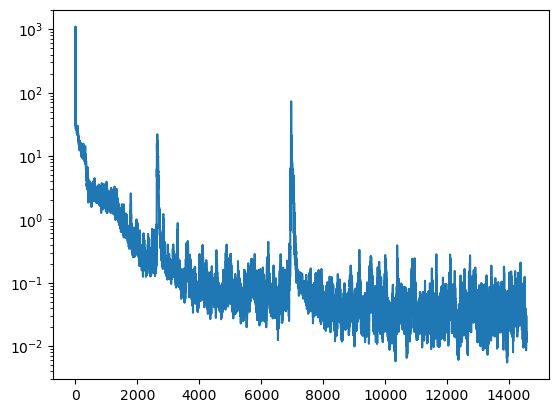

In [32]:
plt.plot(L)
plt.yscale('log')

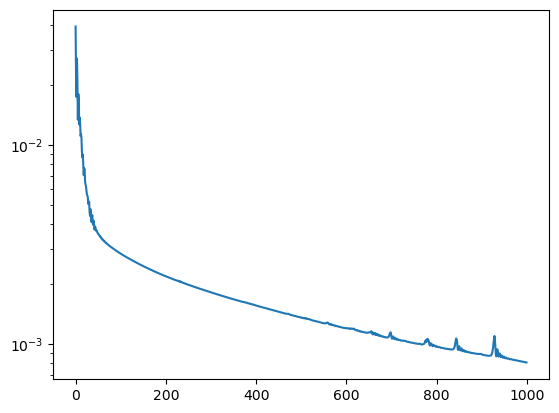

In [33]:
plt.plot(Ll)
plt.yscale('log')

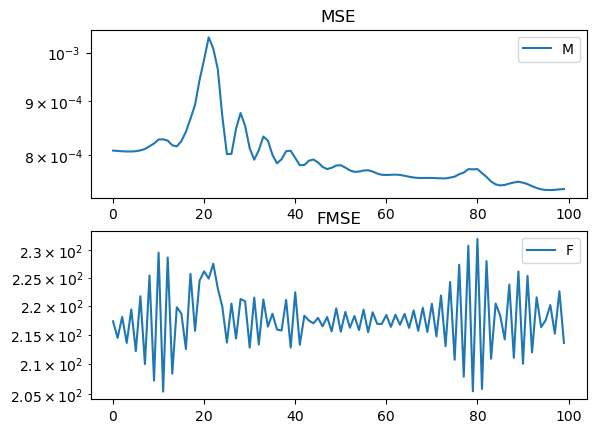

In [34]:
l2.plot()

100%|██████████| 200/200 [00:20<00:00,  9.64it/s]


GIF successfully saved at combo_test.gif


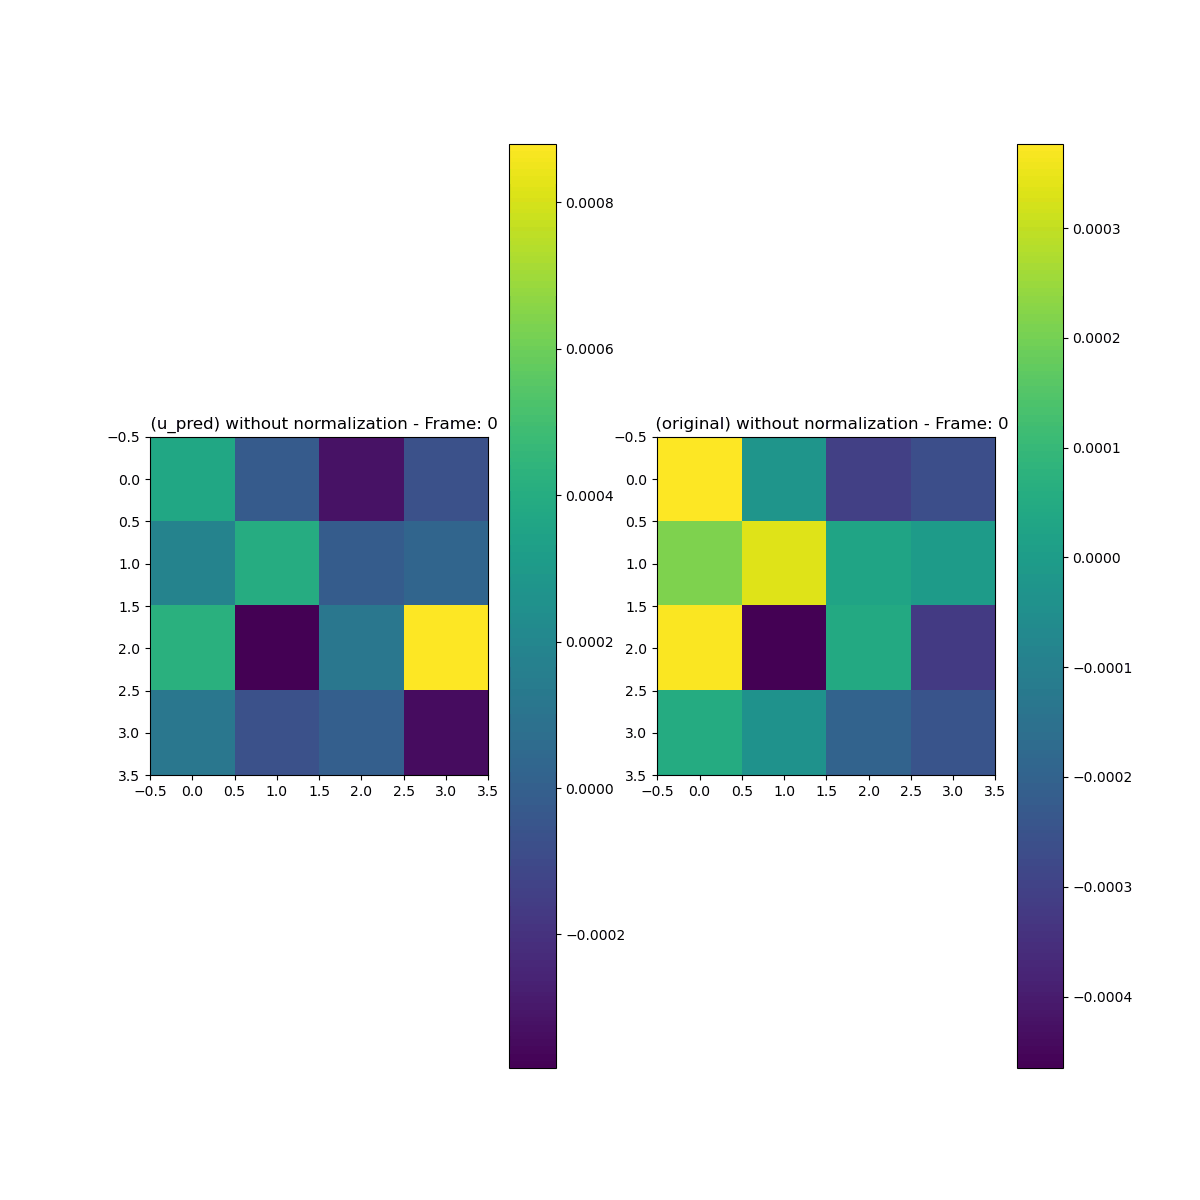

In [141]:
path="combo_test"
create_gifs(
    memory_rate=mem_rate,
    u_pred=net.predict(X_star).reshape(1,200,4,4),
    original=A_original,
    save=True,
    path_for_gif=path+".gif",
    duration=500,
    title=" "
)
Image(filename=path+".gif")

# Continue building Neural network based on the previous net

In [46]:
# # Save all the data to not run the code all over again
# !mkdir data
# np.save("data/p.npy",net.predict(X_star))
# np.save("data/x.npy",X_star)
# np.save("data/y.npy",A_original.reshape(-1))


In [2]:
import cv2
import torch
import imageio
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

from tqdm.notebook import tqdm
from torch import Tensor
from itertools import compress, cycle
from collections import OrderedDict
from scipy.interpolate import griddata
from IPython.display import Image

from utilities.utils import *

from src.plotting import Plotter
from src.gl_solver import GLSolver
from src.parameters_init import ParametersInit
from src.random_input_field import RandomInputField

import warnings
warnings.filterwarnings('ignore')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
X = np.load("data/x.npy") # X
Y = np.load("data/y.npy") # Y
P = np.load("data/p.npy") # Predicted
Y = np.array((np.real(Y),np.imag(Y))).T
P = np.array((np.real(P),np.imag(P))).T

In [21]:
class VAHANNETCONT(VAHANNET):
    def fastmsetraincont(self, x, y, p, epochs=100):
        self.optimizer.param_groups[0]['lr'] = 0.001
        x = torch.tensor(x, dtype = torch.float64).to(device)
        y = torch.tensor(y, dtype = torch.float64).to(device)
        p = torch.tensor(p, dtype = torch.float64).to(device)
        
        self.optimizer.zero_grad()
        msef = nn.MSELoss()
        absf = nn.L1Loss()
        L = []
        
        def closure():
          if torch.is_grad_enabled():
            optimizer.zero_grad()
          output = model(input)
          loss = loss_fn(output, target)
          if loss.requires_grad:
            loss.backward()
          return loss  
        
        
        
        for _ in tqdm(range(epochs)):
            y_pred = self.forward(x)
            L.append(msef(y_pred + p,y).cpu().detach().numpy())
            absf(y_pred + p,y).backward()
            self.optimizer.step()
            self._nn.zero_grad()       

        return L    


In [22]:
net2 = net.fastmsetraincont(x = X, y = Y, p = P, epochs = 1000)

100%|██████████| 1000/1000 [00:03<00:00, 325.36it/s]


In [ ]:
n

In [10]:
import torch
torch.cuda.empty_cache()
torch.autograd.set_detect_anomaly(False)
torch.manual_seed(1)
net = VAHANNETCONT([3,16,64,16,2]).to(device)
L = net.fastmsetraincont(x = X, y = Y, p = P, epochs = 80)
L = net.fastmsetraincont(x = X, y = Y, p = P, epochs = 300000)

100%|██████████| 300000/300000 [14:26<00:00, 346.09it/s]


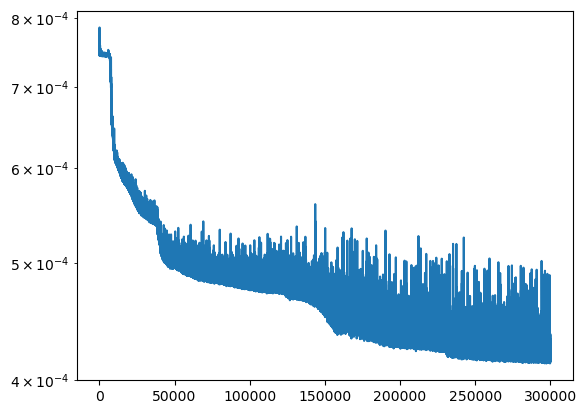

In [11]:
plt.plot(L)
plt.yscale('log')

In [12]:
np.min(L)

0.0004126285303554786

In [19]:
net.optimizer.param_groups[0]['lr'] = 0.001

In [20]:
net.optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.001
    maximize: False
    weight_decay: 0
)